In [1]:
import io
import os
import cv2
import random
import string
import shutil
import pathlib
import itertools
import math
import shap

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [79]:
from sklearn.ensemble import RandomForestClassifier
from explainerdashboard import ExplainerDashboard,ClassifierExplainer,RegressionExplainer,ExplainerHub
from helper_functions import get_radiomics_dataset
from tensorflow import keras
from sklearn import metrics
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from helper_functions import image_plot,ds_to_array,get_augmenter,plot_confusion_matrix

## Define paths

In [4]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
data_path               = os.path.join(parent_path, "01-Datasets/data/radiomics")
model_path_parent       = os.path.join(parent_path, "03-Models/")
tensorboard_path_parent = os.path.join(parent_path, "04-Logs/03-Task3")

## Hyperparameter

In [113]:
model_name      = "cnn_tabular"
epochs          = 100  
learning_rate   = 1e-3
batch_size      = 64

## Load Data

In [122]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = get_radiomics_dataset(data_path)
full_test_data = pd.concat([val_data,test_data],ignore_index=True)
full_test_labels = np.concatenate([val_labels,test_labels])

In [123]:
# A utility method to create a tf.data dataset from a Pandas Dataframe and standardize
def df_to_dataset(dataframe,labels, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [124]:
train_ds = df_to_dataset(train_data,train_labels, batch_size=batch_size)
test_ds = df_to_dataset(full_test_data,full_test_labels, shuffle=False, batch_size=batch_size)

In [88]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = tf.keras.layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

## Callbacks

In [125]:
tensorboard_path = os.path.join(tensorboard_path_parent, model_name)
try:
    shutil.rmtree(tensorboard_path)
except:
    pass    
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode ="min",
    patience=3,
    restore_best_weights=True,
)
tc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(test_ds)
    test_pred = (test_pred > 0.5).astype(np.int8)
    cm = metrics.confusion_matrix(full_test_labels, test_pred)
    normalize = False
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    classes=["No","Yes"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
    
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks = [es,tc,cm_callback]

In [61]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in tqdm(train_data.columns.values.tolist()):
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

100%|████████████████████████████████████████████████████████████████████████████████| 474/474 [05:18<00:00,  1.49it/s]


In [126]:
tf.keras.backend.clear_session()
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

In [127]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [128]:
model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 17s 3s/step - loss: 0.8645 - accuracy: 0.5901 - val_loss: 0.6789 - val_accuracy: 0.4821
Epoch 2/100
4/4 [==============================] - 4s 468ms/step - loss: 0.5499 - accuracy: 0.7523 - val_loss: 0.6646 - val_accuracy: 0.6071
Epoch 3/100
4/4 [==============================] - 1s 435ms/step - loss: 0.3547 - accuracy: 0.8559 - val_loss: 0.6359 - val_accuracy: 0.6607
Epoch 4/100
4/4 [==============================] - 2s 457ms/step - loss: 0.2316 - accuracy: 0.9144 - val_loss: 0.6161 - val_accuracy: 0.7500
Epoch 5/100
4/4 [==============================] - 1s 440ms/step - loss: 0.2796 - accuracy: 0.8649 - val_loss: 0.5971 - val_accuracy: 0.7857
Epoch 6/100
4/4 [==============================] - 1s 431ms/step - loss: 0.2161 - accuracy: 0.8964 - val_loss: 0.5748 - val_accuracy: 0.7679
Epoch 7/100
4/4 [==============================] - 1s 437ms/step - loss: 0.2029 - accuracy: 0.9189 - val_loss: 0.5646 - val_accuracy: 0.7679
Epoch 8/100
4/4

## Model Evaluation

Test F1 score : 0.7268
Test ACC score : 0.7857
Confusion matrix, without normalization
[[ 9  8]
 [ 4 35]]


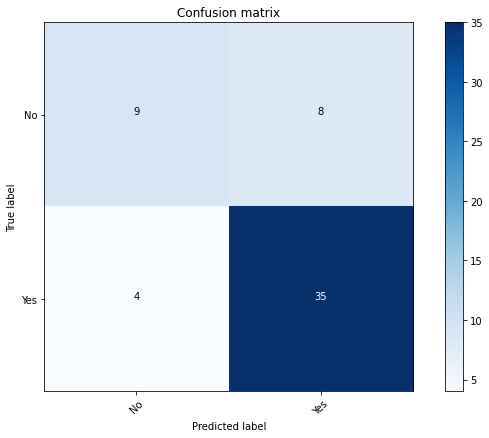

In [131]:
y_pred = model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(np.int8)

f1 = f1_score(full_test_labels, y_pred, average="macro")
acc = accuracy_score(full_test_labels, y_pred)

print("Test F1 score : {:.4f}".format(np.mean(f1)))
print("Test ACC score : {:.4f}".format(np.mean(acc)))


plot_confusion_matrix(full_test_labels,y_pred,["No","Yes"])


## Compare all classifiers, while only looking at certain figures
### highly recommended to only set True the one you are intrested (reduces time to load whats needed)

In [162]:
X_test  =full_test_data
X_train =train_data

In [163]:
def f(X):
    return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [165]:
explainer = shap.KernelExplainer(f, X_train.iloc[:100,:])
shap_values = explainer.shap_values(X_test.iloc[20,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[20,:])

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [167]:
shap_values20 = explainer.shap_values(X_test.iloc[0:5,:], nsamples=500)

  0%|          | 0/5 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [168]:
shap.force_plot(explainer.expected_value, shap_values20, X_test.iloc[0:5,:])

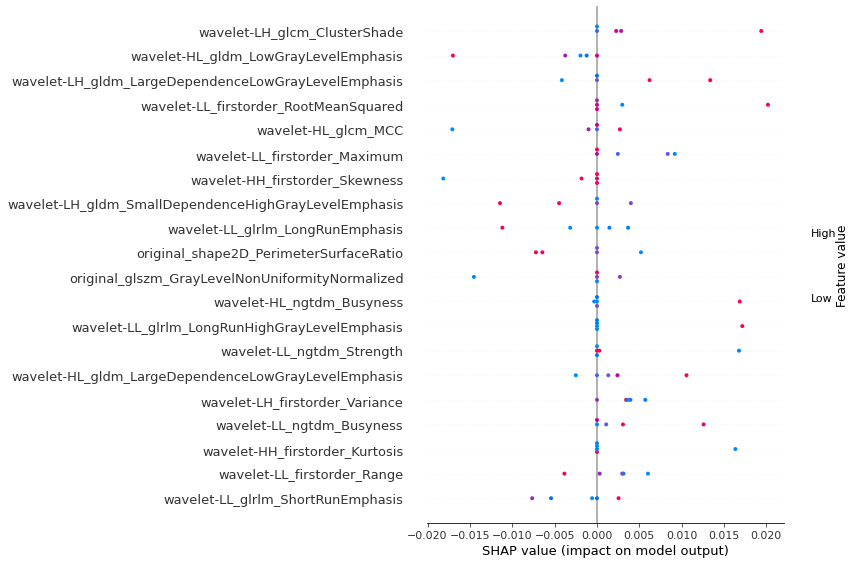

In [171]:
shap.summary_plot(shap_values = shap_values20,
                  features = X_test.iloc[0:5,:]
                  )

In [183]:
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
sv = explainer(X_test.iloc[0:50,:],max_evals=1000)

Permutation explainer: 11it [01:08,  7.60s/it]                                                                         


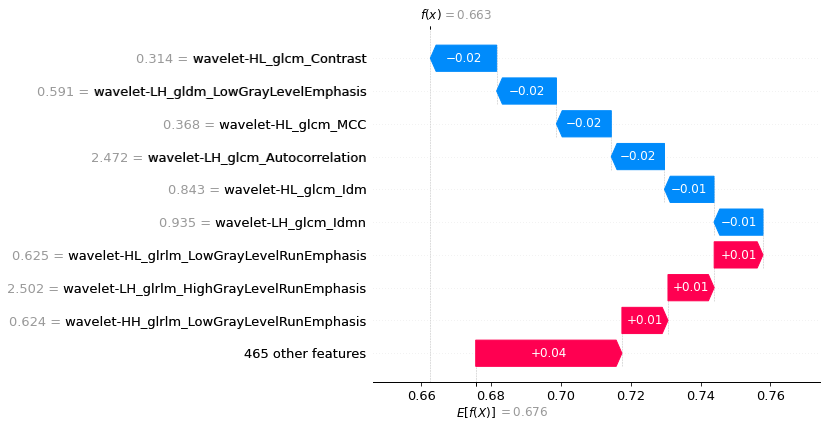

In [184]:
shap.plots.waterfall(sv[0])

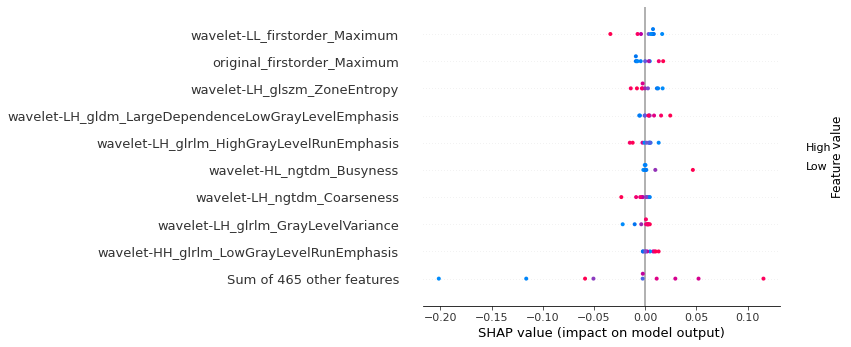

In [185]:
shap.plots.beeswarm(sv)

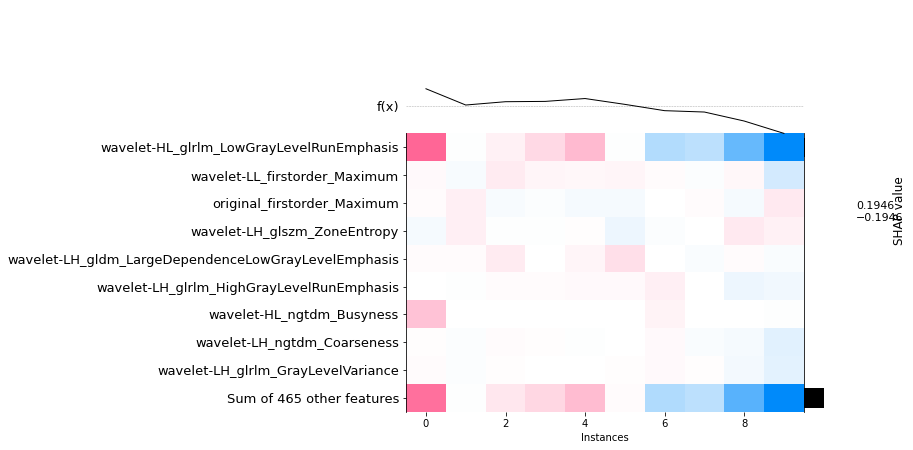

In [186]:
shap.plots.heatmap(sv)
